In [4]:
import os
import glob
import pandas as pd
import json
import re

raw_data_path = "/data/kiwan/dataset-CWD-10/"
signal_types = ['Barker', 'Costas', 'Frank', 'LFM', 'P1', 'P2', 'P3', 'P4']

output_json = 'CWD signal dataset.json'

signals_dict = {}

def extract_snr_from_filename(filename):
    match = re.search(r'snr-?0*(\d+)', filename)
    if match:
        return int(match.group(1))
    return None

for signal in signal_types:
    signal_csvs = glob.glob(os.path.join(raw_data_path, signal, '*.csv'))
    signals_dict[signal] = {}  
    
    for csv_file in signal_csvs:
        snr_value = extract_snr_from_filename(csv_file)
        print(f"Processing {csv_file} with SNR {snr_value}")
        
        if snr_value is not None:
            df = pd.read_csv(csv_file, header=None)
            
            if snr_value not in signals_dict[signal]:
                signals_dict[signal][snr_value] = []
            
            signals_dict[signal][snr_value].extend(df.values.tolist())
        else:
            print(f"Warning: SNR not found in {csv_file}")

with open(output_json, 'w') as f:
    json.dump(signals_dict, f, indent=4)

print(f"All signals have been merged by SNR into {output_json}")


Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00001.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00002.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00003.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00004.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00005.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00006.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00007.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00008.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00009.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00010.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00011.csv with SNR 10
Processing /data/kiwan/dataset-CWD-10/Barker/barker-snr-10-no00012.csv with SNR 10
Proc

In [2]:
import os
import argparse

import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import _config as c
from model import BiLSTM, collate
    
criterion = nn.CrossEntropyLoss()

parser = argparse.ArgumentParser(description='Training parameters')
parser.add_argument('-m', '--mode', type=str, default='train', help='Mode of operation (train/eval)')

parser.add_argument('-smin','--snr_min', type=int, default=0, help='Minimum SNR value')
parser.add_argument('-smax','--snr_max', type=int, default=16, help='Maximum SNR value')
parser.add_argument('--split_size', type=float, default=0.8, help='Train/Test split size')
parser.add_argument('--batch_size', type=int, default=64, help='Batch size for training')
parser.add_argument('--num_epochs', type=int, default=500, help='Number of epochs for training')
parser.add_argument('--learning_rate', type=float, default=0.001, help='Learning rate for optimizer')
parser.add_argument('--weight_decay', type=float, default=1e-5, help='Weight decay for optimizer')
parser.add_argument('--input_size', type=int, default=2, help='Input size for the model')
parser.add_argument('--hidden_size', type=int, default=128, help='Hidden size for the model')
parser.add_argument('--num_layers', type=int, default=2, help='Number of layers in the model')
parser.add_argument('--num_classes', type=int, default=len(c.signalTypes[:c.typeSize]), help='Number of output classes')

args = parser.parse_args(args=[])

params = {
    'snr_min': args.snr_min,
    'snr_max': args.snr_max,
    'split_size': args.split_size,
    'batch_size': args.batch_size,
    'num_epochs': args.num_epochs,
    'learning_rate': args.learning_rate,
    'weight_decay': args.weight_decay,
    'input_size': args.input_size,
    'hidden_size': args.hidden_size,
    'num_layers': args.num_layers,
    'num_classes': args.num_classes
}

def train_set(dataset):
    print(f"Size of train dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        print(f"\nTraining model for SNR: {snr}...")
        ckpt = os.path.join("./ckpts/", snr_str:=f"-{snr}dB" if snr != 0 else "0dB")
        os.makedirs(ckpt, exist_ok=True)
        
        LSTMmodel = BiLSTM(params['input_size'], params['hidden_size'], 
                    params['num_layers'], params['num_classes']).to(c.device)
        optimizer = optim.Adam(LSTMmodel.parameters(), lr=params['learning_rate'], 
                                                    weight_decay=params['weight_decay'])
        
        snr_dataset = [(data, label, data_snr) for data, label, data_snr in dataset if data_snr == snr]
        snr_loader = DataLoader(snr_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=collate)
            
        best_state, best_loss = LSTMmodel.train_model(snr_loader, criterion, optimizer, params['num_epochs'], c.device, snr_str, ckpt)

        save_point = f'{ckpt}/LSTM_{snr_str}_{best_loss:.4f}.pt'
        
        torch.save(best_state, save_point)
        print(f"Model checkpoint saved at {save_point}")

def eval_set(dataset):
    print(f"Size of test dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        ckpt = os.path.join("./ckpts/", snr_str:=f"-{snr}dB" if snr != 0 else "0dB")
        ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt")]
        
        LSTMmodel = BiLSTM(params['input_size'], params['hidden_size'], 
                    params['num_layers'], params['num_classes']).to(c.device)
        LSTMmodel.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
        LSTMmodel.eval()
        
        snr_dataset = [(data, label, data_snr) for data, label, data_snr in dataset if data_snr == snr]
        snr_loader = DataLoader(snr_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=collate)
        
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in snr_loader:
                data, labels = batch[0].to(c.device), batch[1].to(c.device)
                outputs = LSTMmodel(data)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
        acc = correct / total * 100
        avg_loss = total_loss / len(snr_loader)
        
        print(f"SNR -{snr}dB | Accuracy: {acc:.2f}% | Average Loss: {avg_loss:.4f}")

# def explain_mode(dataset):
#     print(f"Size of test dataset: {len(dataset)}")
#     for snr in range(params['snr_min'], params['snr_max']+1, 2):
#         ckpt = os.path.join("./ckpts/", snr_str:=f"-{snr}dB" if snr != 0 else "0dB")
#         ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt")]

#         LSTMmodel = BiLSTM(params['input_size'], params['hidden_size'], 
#                     params['num_layers'], params['num_classes']).to(c.device)
#         LSTMmodel.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
#         LSTMmodel.train() # train mode for SHAP
        
#         explainer = None
#         dataset_batch = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=collate)
#         for data, labels, _ in dataset_batch:
#             data = data.to(c.device)
            
#             if explainer is None:
#                 explainer = shap.GradientExplainer(LSTMmodel, data)
            
#             LSTMmodel.train()
#             shap_values = explainer.shap_values(data)
#             for shap in shap_values:
                
                
#             print(shap_values.shape, data.shape)    # (64, 1835, 2, 4) torch.Size([64, 1835, 2])
#             shap.summary_plot(shap_values, data.cpu().numpy())
            
#             plt.show()
#             break
        
from RadarDataset import RadarSignalDataset  
mode = 'explain'
if __name__ == "__main__":
    if mode == 'train':
        train_dataset = RadarSignalDataset(c.TrainData, c.signalTypes[0:c.typeSize], snr_max=17)
        train_set(train_dataset)
    elif mode == 'eval':
        test_dataset = RadarSignalDataset(c.TestData, c.signalTypes[0:c.typeSize], snr_max=17)
        eval_set(test_dataset)
    elif mode == 'explain':
        explain_dataset = RadarSignalDataset(c.TestData, c.signalTypes[0:c.typeSize], snr_max=17)
        # explain_mode(explain_dataset)

Data loading for 'Barker'.....Done!
Data loading for 'Costas'.....Done!
Data loading for 'Frank'.....Done!
Data loading for 'LFM'.....Done!


Size of test dataset: 7200


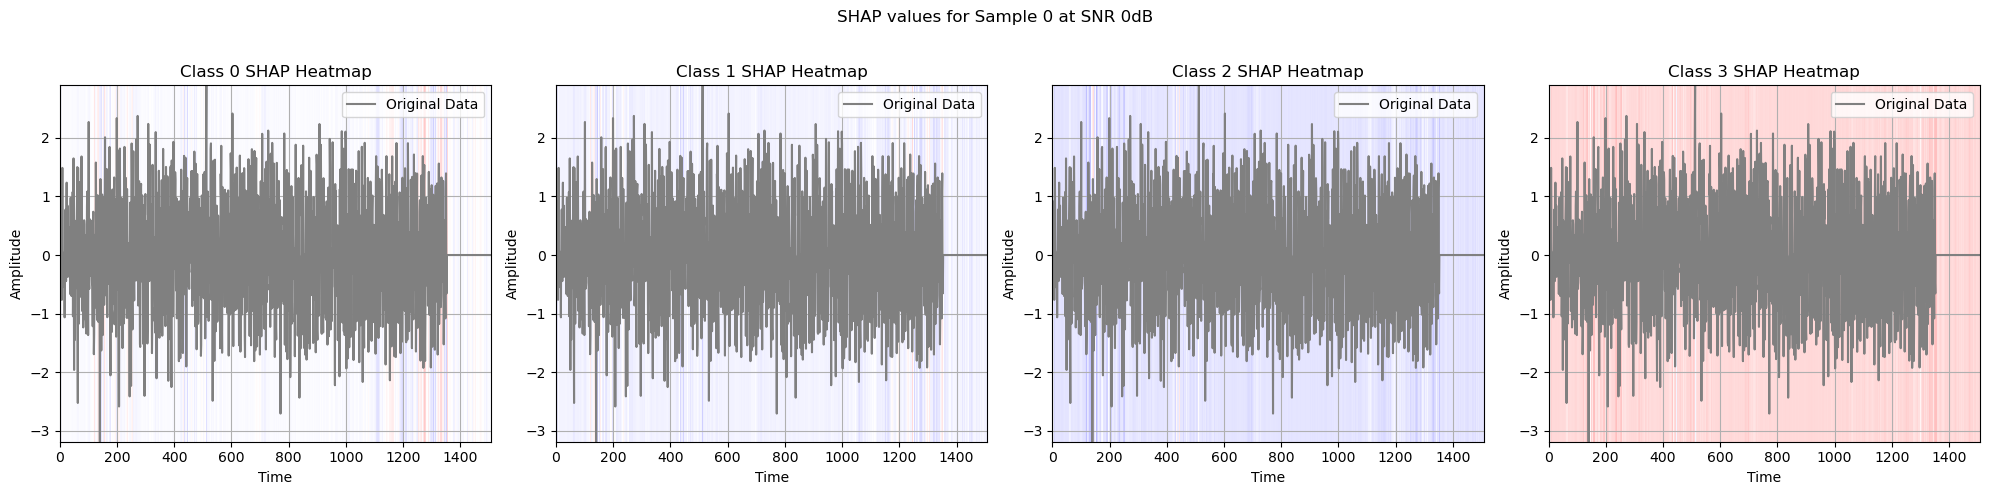

In [20]:
import numpy as np
def explain_mode(dataset):
    print(f"Size of test dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        ckpt = os.path.join("./ckpts/", snr_str:=f"-{snr}dB" if snr != 0 else "0dB")
        ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt")]

        LSTMmodel = BiLSTM(params['input_size'], params['hidden_size'], 
                    params['num_layers'], params['num_classes']).to(c.device)
        LSTMmodel.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
        LSTMmodel.train() # train mode for SHAP
        
        explainer = None
        dataset_batch = DataLoader(dataset, batch_size=params['batch_size'], shuffle=False, collate_fn=collate)
        for data, labels, _ in dataset_batch:
            data = data.to(c.device)
            
            if explainer is None:
                explainer = shap.GradientExplainer(LSTMmodel, data)
            
            LSTMmodel.train()
            shap_values = explainer.shap_values(data)  # shap : (64, 1835, 2, 4) / data :torch.Size([64, 1835, 2])     
            
            num_classes = shap_values.shape[3]
            for i in range(data.shape[0]):
                fig, axs = plt.subplots(1, num_classes, figsize=(20, 5))
                for class_idx in range(num_classes): 
                    shap_class = shap_values[i, :, :, class_idx]
                    
                    real_shap = shap_class[:, 0]
                    imag_shap = shap_class[:, 1]
                    
                    real_data = data[i, :, 0].cpu().numpy()
                    imag_data = data[i, :, 1].cpu().numpy()
                    
                    # 히트맵
                    time = np.linspace(0, len(real_data), len(real_data))
                    shap_score = real_shap
                    
                    axs[class_idx].plot(time, real_data, color='gray', label='Original Data') # plot(x, y)
                    axs[class_idx].imshow(shap_score[np.newaxis, :], cmap='bwr', aspect='auto', extent=[0, len(real_data), np.min(real_data), np.max(real_data)], alpha=0.5)
                    
                    axs[class_idx].set_title(f'Class {class_idx} SHAP Heatmap')
                    axs[class_idx].set_xlabel('Time')
                    axs[class_idx].set_ylabel('Amplitude')
                    axs[class_idx].legend()
                    axs[class_idx].grid(True)
                    
                plt.suptitle(f'SHAP values for Sample {i} at SNR {snr_str}')
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()
                break
            break
        break  
        
explain_mode(explain_dataset)

In [1]:
import os
import re
import torch
import glob
import json

import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from TripletConvolution import TCN, trainTCN

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

signalTypes = ['Barker', 'Costas', 'Frank', 'LFM', 'P1', 'P2', 'P3', 'P4', 'T1', 'T2', 'T3', 'T4']

RawType = "/data/kiwan/dataset-CWD-50/"
TransformedTypes = {'DWT' : "/data/kiwan/Unknown_radar_detection/Adaptive_wavelet_transform/dataset-SPWVD-denoised-Adaptive_DWT",
                    'CWD' : "/data/kiwan/Unknown_radar_detection/Adaptive_wavelet_transform/240523_CWD-v1/",
                    'SAFI' : "/data/kiwan/Unknown_radar_detection/Adaptive_wavelet_transform/240523_SAFI-v1/",}


In [6]:
json_file = 'dataset/CWD_signals.json'

with open(json_file, 'r') as f:
    SignalData = json.load(f)

In [65]:
# [signal_type]>[snr_value]>[step]>[timepoint][real, imag]

import matplotlib.pyplot as plt
from torch.utils.data import Dataset


import torch.nn.utils.rnn as rnn_utils

class RadarSignalDataset(Dataset):
    def __init__(self, signals_data, signal_types, snr_max=17):
        self.data = []
        self.labels = []
        self.label_mapping = {signal: idx for idx, signal in enumerate(signalTypes)}

        for signal_type in signal_types:
            print(f"Data loading for '{signal_type}'", end='')
            for snr_idx, snr in enumerate(range(0, snr_max, 2)): 
                print(".", end='') if snr_idx % 2 == 0 else None
                ssnr = str(snr)
                if ssnr in signals_data[signal_type]: 
                    signal_snr_data = signals_data[signal_type][ssnr]
                    for signal in signal_snr_data:
                        complex_signal = [self.convIQ(x) for x in signal]
                        self.data.append(complex_signal)
                        self.labels.append(signal_type)
            print("Done!")
    
    @staticmethod
    def convIQ(datastring):
        comp = complex(datastring.replace('i', 'j'))
        return comp.real, comp.imag
    
    staticmethod
    def collate(self, batch):
        data, labels = zip(*batch)
        padding = rnn_utils.pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in data], batch_first=True)
        labels = [self.label_mapping[label] for label in labels]
        labels = torch.tensor(labels, dtype=torch.long)
        return padding, labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [66]:
typeSize = 4
dataset = RadarSignalDataset(SignalData, signalTypes[0:typeSize], snr_max=17)

Data loading for 'Barker'.....Done!
Data loading for 'Costas'.....Done!
Data loading for 'Frank'.....Done!
Data loading for 'LFM'.....Done!


In [68]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)

Train batch data size: torch.Size([32, 1856, 2])
Train batch labels: torch.Size([32])
Test batch data size: torch.Size([32, 1920, 2])
Test batch labels: torch.Size([32])


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initial hidden state와 cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))     # LSTM 출력: (배치 크기, 시퀀스 길이, hidden state 크기)
        out = self.fc(out[:, -1, :])        # 마지막 타임스텝만 사용하여 출력 계산
        return out

input_size = 2          # (Real, Imag)
hidden_size = 128       # LSTM hidden state size
num_layers = 2          
num_classes = len(signalTypes[:typeSize])  # Expected Output size

model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [74]:
num_epochs = 40 
batch_size = 128

for epoch in range(num_epochs):
    model.train()  
    rl = 0.0
    
    for data_batch, labels_batch in train_loader:
        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(data_batch)

        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        rl += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {rl/len(train_loader):.4f}')
torch.save(model.state_dict(), f'./lstm_l{rl/len(train_loader):.4f}.pt')

model.eval() 
correct = 0
total = 0

with torch.no_grad():
    for data_batch, labels_batch in test_loader:
        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device)
        outputs = model(data_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Epoch [1/40], Loss: 0.4966
Epoch [2/40], Loss: 0.4733
Epoch [3/40], Loss: 0.3970
Epoch [4/40], Loss: 0.5445
Epoch [5/40], Loss: 0.5509
Epoch [6/40], Loss: 0.4634
Epoch [7/40], Loss: 0.3565
Epoch [8/40], Loss: 0.3428
Epoch [9/40], Loss: 0.4956
Epoch [10/40], Loss: 0.5562
Epoch [11/40], Loss: 0.4643
Epoch [12/40], Loss: 0.3316
Epoch [13/40], Loss: 0.2909
Epoch [14/40], Loss: 0.6296
Epoch [15/40], Loss: 0.7437
Epoch [16/40], Loss: 0.5196
Epoch [17/40], Loss: 0.5252


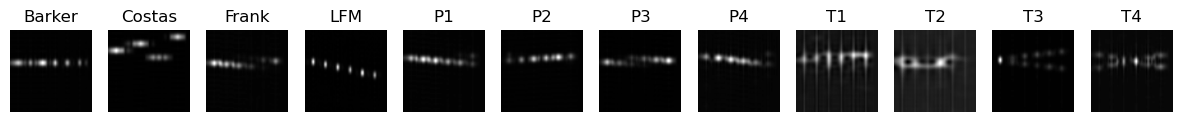

In [5]:
version = 0
targetSNR = 0

vDataset = [(d,l,s) for d, l, s, _ in Dataset if s == targetSNR and signalTypes[l] in signal_groups[f'v{version}']]

plot = {}
for data, label, _ in vDataset:
    signalType = signalTypes[label]
    if signalType not in plot:
        plot[signalType] = data

fig, axs = plt.subplots(1, len(plot))
fig.set_size_inches(15, 5)

for i, (signal_type, image) in enumerate(plot.items()):
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].set_title(signal_type)
    axs[i].axis('off')

plt.show()

In [ ]:
tcn = TCN(input_channel=1).cuda() 
optimizer = optim.Adam(tcn.parameters(), lr=1e-4)


maxSNR = 2
unique_labels = np.unique([l for _, l, _ in vDataset])

for snr in range(0, maxSNR, 2):
    snrDataset = [(d,l,s) for d, l, s in vDataset if s == snr]
    trainTCN(tcn, optim=optimizer, dataset=snrDataset, data_type='DWT', snr=snr, epochs=20)